In [ ]:
# Importing Packages
import numpy as np
from scipy.stats import norm
from scipy.special import erfinv
import matplotlib.pyplot as plt
import math as m
import random as r
import pandas as pd

In [ ]:
#reading file
agg = pd.read_csv("AGG.csv")
nasdaq = pd.read_csv("^IXIC.csv")

In [ ]:
agg.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-17,107.849998,108.059998,107.730003,107.860001,105.224762,8035400
1,2022-03-18,107.930000,108.139999,107.919998,108.099998,105.458885,7864100
2,2022-03-21,107.580002,107.650002,106.980003,107.040001,104.424789,8024800
3,2022-03-22,106.739998,106.879997,106.610001,106.750000,104.141861,16120500
4,2022-03-23,106.959999,107.209999,106.709999,107.190002,104.571121,9060700


In [ ]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-17,13360.719727,13620.799805,13317.139648,13614.780273,13614.780273,5612090000
1,2022-03-18,13564.629883,13899.280273,13528.059570,13893.839844,13893.839844,8149290000
2,2022-03-21,13860.389648,13945.809570,13682.549805,13838.459961,13838.459961,5673940000
3,2022-03-22,13866.429688,14141.070313,13857.290039,14108.820313,14108.820313,5445100000
4,2022-03-23,13990.349609,14152.139648,13921.650391,13922.599609,13922.599609,5024230000


In [ ]:
#general share info
aggprice = agg["Close"]
agg_return = [(aggprice[i] - aggprice[i-1]) / aggprice[i-1] for i in range(1, len(agg.index))]
agg_expected = 0.02
agg_stdev = np.std(agg_return) * len(agg.index)**0.5

nasdaqprice = nasdaq["Close"]
nasdaq_return = [(nasdaqprice[i] - nasdaqprice[i-1]) / nasdaqprice[i-1] for i in range(1, len(nasdaq.index))]
nasdaq_expected = 0.07
nasdaq_stdev = np.std(nasdaq_return) * len(nasdaq.index)**0.5

def cov(x,y): 
  dx = x - np.mean(x)
  dy = y - np.mean(y)
  return np.dot(dx,dy)/(len(x))

cov = cov(nasdaq_return, agg_return) * len(agg.index)

print(agg_stdev)
print(nasdaq_stdev)
print(cov)

0.08284338759008895
0.3020918419285206
0.008476299273116435


In [ ]:
#applying monte carlo simulation
np.random.seed(0)
simul = 10000
alpha = 0.1

#current portfolio value
current = 100000

#rate
nasdaq_rate = 0.7
agg_rate = 1 - nasdaq_rate

#portfolio variance and standard deviation
port_var = nasdaq_rate ** 2 * nasdaq_stdev ** 2 + agg_rate **2 * agg_stdev ** 2 + 2*nasdaq_rate * agg_rate * cov
port_std = port_var ** 1/2

print(port_var)
print(port_std)

0.04889486378306053
0.024447431891530265


In [ ]:
#VAR
days = 10
import scipy.stats as stats
Z = stats.norm.ppf(np.random.rand(10, 20000))

expected_return = current * (float(nasdaq_rate) * float(nasdaq_expected) + float(agg_rate) * float(agg_expected)) * (days / len(agg.index))

var_scenario = expected_return - (nasdaq_rate * port_var * Z.mean() * (days / len(agg.index) ** 0.5))
var_scenario

219.12344454132125

In [ ]:
# Remember that we want to find the optimal portfolio weights that maximize the expected return while keeping the VaR below a certain threshold.
# Rates
nasdaq_rates = np.linspace(0.1, 0.9, 9)  # weights range from 10% to 90% in increments of 10%
agg_rates = 1 - nasdaq_rates 

# Create empty table
table = pd.DataFrame(index=nasdaq_rates, columns=['Expected Return', 'VaR']) # row indices corresponding to the possible NASDAQ weights

# So our purpose is to estimated the expected return and VaR for each possible portfolio weight combination, and fill in the table with these estimates

VaR를 일정 임계치 이하로 유지하면서 기대수익률을 극대화하는 최적의 포트폴리오 가중치를 찾는 것이 목표.\
따라서 가중치를 10%씩 증분하여 10%에서 90% 범위를 nasdaq_rate으로 정의한 후, 나머지를 agg_rate로 정의.

In [ ]:
#Monte Carlo Simulation
days = 10
norm_Z = stats.norm.ppf(np.random.rand(days, simul))  # create a matrix of normally distributed random variables
var_mc = np.zeros(simul)  #create an array of length 'simul' filled with zeros, which will be used to store the results of the Monte Carlo simulation

# Loop over each nasdaq_rate value in the nasdaq_rates array and its corresponding agg_rate value in the agg_rates array
for i, nasdaq_rate in enumerate(nasdaq_rates):    #loop that iterates through the nasdaq_rates array, and uses the enumerate function to keep track of the current index i and value nasdaq_rate
    agg_rate = agg_rates[i] #set agg_rate equal to the corresponding value in agg_rates based on the index i
    # Portfolio variance and standard deviation
    port_var = nasdaq_rate ** 2 * nasdaq_stdev ** 2 + agg_rate **2 * agg_stdev ** 2 + 2*nasdaq_rate * agg_rate * cov
    port_std = port_var ** 0.5
    # Expected return
    expected_return = current * (float(nasdaq_rate) * float(nasdaq_expected) + float(agg_rate) * float(agg_expected)) * (days / len(agg.index))
    # Monte Carlo simulation of VaR (calculating simulated returns of the portfolio)
    portfolio_returns = expected_return - (nasdaq_rate * port_var * norm_Z.mean() * (days / len(agg.index) ** 0.5))
    portfolio_returns = portfolio_returns.ravel()
    percentile = np.percentile(portfolio_returns, q = 100 - alpha * 100, interpolation = "higher")  # calculating VaR by taking the percintile of portfolio_returns array based on alpha level
    #참조) VaR은 투자자가 특정 기간 동안 일정 수준의 신뢰를 가지고 손실을 에상할 수 있는 최대 금액으로 정의됨. 따라서 백분위수를 활용해 데이터의 특정 백분률 아래의 값을 계산해 VaR값을 알아내는 것. 

    for j in range(simul):  #loop to iterate simul number of times
        random_returns = np.random.choice(portfolio_returns, size=days, replace=True)   #generating a random sapmle of returns from the portfolio_returns array with replacement (the size of sample = days)
        var_mc[j] = expected_return - (port_std * np.mean(norm_Z[:, j]) * (days / len(agg.index)) ** 0.5) #aka, simulated VaR. calculating simulated VarR using the Monte Carlo formula previously defined.
    var = np.percentile(var_mc, 100 - alpha*100)
    table.loc[nasdaq_rate, 'Expected Return'] = expected_return
    table.loc[nasdaq_rate, 'VaR'] = var

# Print final VaR
final_var = np.percentile(var_mc, 100 - alpha*100)
print('Final VaR:', final_var)

<ipython-input-46-3bab9870db99>:16: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  percentile = np.percentile(portfolio_returns, q = 100 - alpha * 100, interpolation = "higher")


Final VaR: 258.9862949878128


즉, 몬테카를로 시뮬레이션을 통한 VaR의 순서는 다음과 같이 진행된다.
1. 포트폴리오의 수익률을 시뮬레이션 하기 위한 days설정, 정규분포 랜덤 변수의 행렬 norm_Z 생성, 몬에카를로 시뮬레이션 결과를 저장하는 데 사용할 0으로 채워진 길이의 시뮬레이션 배열 var_mc 생성.

2. 두 개의 loop를 생성해 시뮬레이션 돌리기.
2-1. enumerate function을 이용해 nasdaq_rates 배열을 반복하는 루프 설정 후, 현재 인덱스 i와 nadaq_rate 추적. agg_rate의 경우 현재 인덱수 i를 기준으로 동일한 agg_rate를 설정함.

  2-2. 공식 대입 해 포트폴리오 값 계산

  2-3. range function으로 시물레이션 반복.

  2-4. portfolio_returns 배열에서 임의의 반환 샘플 생성 후, var_mc[j]로 반복에 대한 시뮤류레이션 VaR 계산.

3. 최종 VaR 값 확인하기

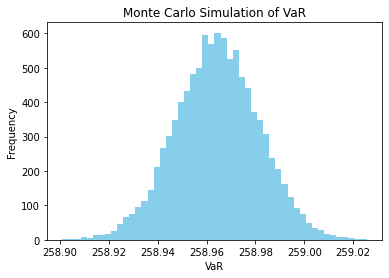

In [ ]:
# Plot histogram of VaR
plt.hist(var_mc, bins=50, color='skyblue')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of VaR')
plt.show()